In [5]:
import os
os.makedirs('models', exist_ok=True)  # ✅ creates it if missing

with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
recipes.to_pickle('models/recipes_mapping.pkl')

NameError: name 'pickle' is not defined

In [ ]:
# ------------------------------
# Semantic recipe search — Excel-ready
# ------------------------------
import pandas as pd
import re
import unicodedata
from sentence_transformers import SentenceTransformer, util
from rapidfuzz import fuzz
import numpy as np


# ---------- helpers ----------
def normalize_text(s):
    if not isinstance(s, str):
        return ""
    s = s.lower().strip()
    s = unicodedata.normalize("NFKD", s)
    s = re.sub(r"[^a-zA-Z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# try to find the best column name from a list
def find_col(df, options):
    for name in options:
        if name in df.columns:
            return name
    return None

# ---------- load Excel ----------
# make sure recipes.xlsx is in the same folder or give full path
df = pd.read_excel("data/recipes.xlsx")

# ---------- identify useful columns ----------
# adapt these lists if your sheet uses different names
name_col = find_col(df, ["recipe_name_orig", "recipe_name", "_recipe_name_orig", "RecipeName", "translatedRecipeName"])
ing_col  = find_col(df, ["ingredient_name_org", "ingredient_name", "ingredient", "Ingredient_Name", "food_name_org"])
food_col = find_col(df, ["food_name_org", "food_name", "food", "Food_Name", "translatedIngredients"])

if not name_col:
    raise KeyError("No recipe name column found. Check your Excel headers (tried several options).")

# If we have both an ingredient and a food column, combine them; otherwise use whichever exists
def combine_row_text(row):
    parts = []
    if ing_col and ing_col in row and pd.notna(row[ing_col]):
        parts.append(str(row[ing_col]))
    if food_col and food_col in row and pd.notna(row[food_col]):
        parts.append(str(row[food_col]))
    return " ".join(parts).strip()

df["combined_text"] = df.apply(combine_row_text, axis=1)

df = df.dropna(subset=[name_col]).reset_index(drop=True)

# if combined_text is empty for many rows, that's fine — we'll still include them but they may be low-quality
print(f"Loaded {len(df)} rows. Using recipe-name column: '{name_col}'. ingredient/food columns: '{ing_col}', '{food_col}'")

# ---------- group into one document per recipe ----------
grouped = (
    df.groupby(name_col)["combined_text"]
      .apply(lambda texts: " ".join([t for t in texts.astype(str) if t.strip() != ""]))
      .reset_index(name="full_text")
)

grouped["clean_text"] = grouped["full_text"].apply(normalize_text)
grouped["recipe_clean"] = grouped[name_col].apply(lambda x: normalize_text(x if pd.notna(x) else ""))

print(f"Number of unique recipes after grouping: {len(grouped)}")

# ---------- load model and compute embeddings ----------
# install sentence-transformers if needed:
# pip install -U sentence-transformers
#print("Loading SentenceTransformer (this may take a moment)...")
#model = SentenceTransformer("all-mpnet-base-v2")   # stronger model; swap to MiniLM if you need speed
#recipe_embeddings = model.encode(grouped["recipe_clean"] + " " + grouped["clean_text"], convert_to_tensor=True, show_progress_bar=True)
print("Loading SentenceTransformer (this may take a moment)...")
model = SentenceTransformer("all-mpnet-base-v2")  # or use MiniLM for speed
recipe_embeddings = model.encode(
    grouped["recipe_clean"] + " " + grouped["clean_text"],
    convert_to_tensor=True,
    show_progress_bar=True
)

import torch
torch.save(recipe_embeddings, "recipe_embeddings.pt")





Loaded 10271 rows. Using recipe-name column: 'recipe_name'. ingredient/food columns: 'ingredient_name_org', 'food_name_org'
Number of unique recipes after grouping: 1015
Loading SentenceTransformer (this may take a moment)...


Batches: 100%|██████████| 32/32 [00:52<00:00,  1.63s/it]


In [ ]:
# ---------- search function ----------
def search_recipe_semantic(query, top_k=5, min_score=0.30, boost_keywords=None):
    """
    Optimized semantic + fuzzy recipe search.
    Combines sentence-transformer cosine similarity with RapidFuzz partial ratio,
    but only applies fuzzy logic to top semantic candidates (≈200) to avoid slowdown.
    """
    q = normalize_text(query)
    if boost_keywords:
        q = q + " " + " ".join(boost_keywords)

    # Encode query
    q_emb = model.encode(q, convert_to_tensor=True)
    scores = util.cos_sim(q_emb, recipe_embeddings)[0]  # tensor
    semantic_scores = scores.cpu().numpy().flatten()

    # Step 1: take top 200 semantic matches only
    top_idx = np.argsort(-semantic_scores)[:200]

    combined_scores = np.zeros(len(semantic_scores))
    for i in top_idx:
        recipe_name = str(grouped.loc[i, name_col])
        fuzz_score = fuzz.partial_ratio(query.lower(), recipe_name.lower()) / 100
        combined_scores[i] = 0.7 * semantic_scores[i] + 0.3 * fuzz_score  # blend semantic + fuzzy

    # For others, keep pure semantic
    combined_scores[combined_scores == 0] = semantic_scores[combined_scores == 0]

    # Step 2: rank by combined score
    sorted_idx = np.argsort(-combined_scores)

    out = []
    for i in sorted_idx:
        if len(out) >= top_k:
            break
        score = float(combined_scores[i])
        if score < min_score and len(out) >= 1:
            break
        if score < min_score:
            continue
        out.append({
            "recipe_name": grouped.loc[i, name_col],
            "recipe_clean": grouped.loc[i, "recipe_clean"],
            "score": round(score, 4),
            "ingredients_preview": grouped.loc[i, "clean_text"][:250] + ("..." if len(grouped.loc[i, "clean_text"]) > 250 else "")
        })

    # Step 3: fallback if empty
    if not out:
        fallback_idx = np.argsort(-semantic_scores)[:top_k]
        for i in fallback_idx:
            i = int(i)
            out.append({
                "recipe_name": grouped.loc[i, name_col],
                "recipe_clean": grouped.loc[i, "recipe_clean"],
                "score": round(float(semantic_scores[i]), 4),
                "ingredients_preview": grouped.loc[i, "clean_text"][:250] + ("..." if len(grouped.loc[i, "clean_text"]) > 250 else "")
            })
    return out

In [ ]:
# ---------- example usage ----------
results = search_recipe_semantic("paneer", top_k=7, min_score=0.30, boost_keywords=["rice", "curry","masala","gravy","indian", "sabzi"])
print("\nSearch results:")
for r in results:
    print(f"{r['recipe_name']}  (score={r['score']})")
    print("  Ingredients preview:", r['ingredients_preview'])
    print()

NameError: name 'search_recipe_semantic' is not defined

In [ ]:
# Sample queries from your dataset
sample_queries = grouped[name_col].sample(5, random_state=42).tolist()

for q in sample_queries:
    print(f"\n🔍 Query: {q}")
    try:
        results = search_recipe_semantic(q, top_k=5, min_score=0.3)
        for r in results:
            print(f"🍲 {r['recipe_name']}  (score={r['score']:.4f})")
            print(f"   Ingredients: {r['ingredients_preview']}\n")
    except Exception as e:
        print(f"Error: {e}")


🔍 Query: Rajbogh
🍲 Rajbogh  (score=0.5000)
   Ingredients: food colour food colour kewra essence kewra essence reetha reetha refined wheat flour wheat flour refined triticum aestivum pistachionut pistachio nuts pistacla vera milk milk whole cow milk milk whole cow sugar sugar white water water distilled wate...

🍲 Kidney bean curry (Rajmah curry)  (score=0.3833)
   Ingredients: rajmah rajmah red phaseolus vulgaris tomato tomato ripe hybrid solanum lycopersicum coriander leaves coriander leaves coriandrum sativum garlic garlic small clove allium sativum ginger ginger fresh zingiber officinale onion onion big allium cepa turm...

🍲 Rice dal porridge (Chawal dal ki khichdi/khichri)  (score=0.3819)
   Ingredients: rice rice parboiled milled oryza sativa green gram dehusked green gram dal vigna radiata groundnut ground nut arachis hypogea jaggery jaggery cane saccharum officinarum

🍲 Brinjal bhartha (Baingan ka bhartha)  (score=0.3792)
   Ingredients: brinjal brinjal all varieties solanum 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_similar_recipes(query_recipe_name: str, top_n: int = 5):
    """
    Show top similar recipes in a table and a heatmap of similarity scores.
    """
    # Use your existing semantic search function
    results = search_recipe_semantic(query_recipe_name, top_k=top_n)

    if not results:
        print(f"No similar recipes found for '{query_recipe_name}'")
        return

    # Convert results to DataFrame
    df_results = pd.DataFrame(results)

    print("\nTop similar recipes:")
    print(df_results[["recipe_name", "score"]].to_string(index=False))

    # Create heatmap
    scores = [r['score'] for r in results]
    names = [r['recipe_name'] for r in results]

    plt.figure(figsize=(10, 2))
    sns.heatmap(
        [scores],
        annot=True,
        fmt=".3f",
        xticklabels=names,
        yticklabels=[query_recipe_name],
        cmap="YlGnBu"
    )
    plt.title(f"Semantic similarity with '{query_recipe_name}'")
    plt.show()



Top similar recipes:
                                         recipe_name  score
                                       Chicken salad 0.7111
                           Broccoli chicken ala king 0.6349
Beetroot and egg salad (Chukandar aur ande ka salad) 0.6214
                                    Chicken sandwich 0.6179
                           Chicken and tomato towers 0.6173


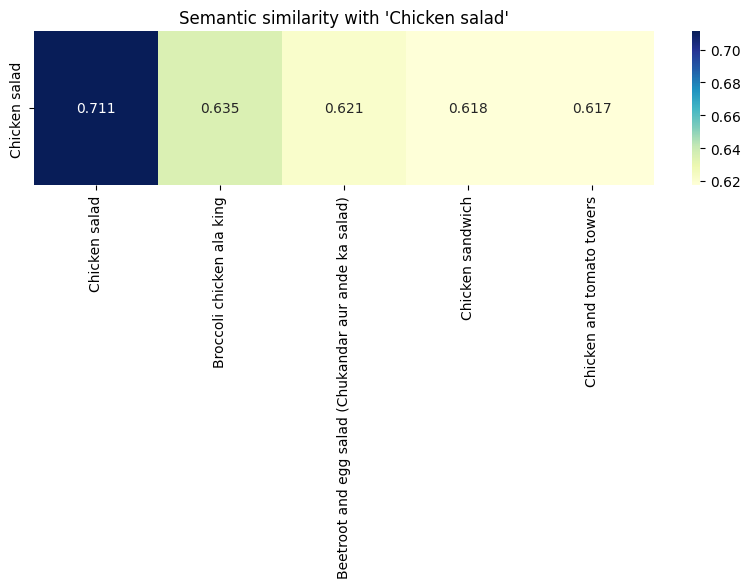

In [ ]:
visualize_similar_recipes("Chicken salad", top_n=5)
